In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.stats as sp

# LEGEND specific imports
from lgdo import lh5, VectorOfVectors, WaveformTable, Table, ArrayOfEqualSizedArrays, Array
from lgdo.lh5 import LH5Store
from dspeed import build_dsp
from dspeed.vis import WaveformBrowser

# P-ONE fastDAQ decoder
from eng_reader import EngFormatReader

# MISC
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import glob


/Users/beatricecrudele/opt/anaconda3/envs/mylegendenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = {
    "outputs": [
        "tp_max",
        "wf_max",
        "charge",
    ],
    "processors":{
        "wf_up": {
            "function": "interpolating_upsampler",
            "module": "dspeed.processors",
            "args": ["waveform", "'h'", "wf_up(len(waveform)*4.8, period=waveform.period/4.8)"],
            "unit": "ADC"
        },
        "wf_av": {
          "function": "moving_window_multi",
          "module": "dspeed.processors",
          "args": ["wf_up", "4", "4", "0", "wf_av"],
          "unit": "ADC/sample"
        },
       "wf_blsub": {
            "function": "subtract",
            "module": "numpy",
            "args": ["wf_av", "2055", "wf_blsub"],
            "unit": "ADC",
        },
        "tp_min, tp_max, wf_min, wf_max": {
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_blsub", "tp_min", "tp_max", "wf_min", "wf_max"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
            "trapEftp": {
            "function": "fixed_time_pickoff",
            "module": "dspeed.processors",
            "args": ["wf_trap", "ftp", "105", "trapEftp"],  # ord('i') == 105
            "unit": "ADC",
        },
        "wf_coin": {
          "function": "windower",
          "module": "dspeed.processors",
          "args": [
            "wf_blsub",
            "tp_max-15*ns",
            "wf_coin(shape=round(30*ns/wf_blsub.period), period=wf_blsub.period, offset=(tp_max-15*ns)/wf_blsub.period)"
          ],
          "unit": ["ADC"]
        },
            "wf_pz": {
            "function": "pole_zero",
            "module": "dspeed.processors",
            "args": ["wf_blsub", "5*us", "wf_pz"],
            "unit": "ADC",
        },
            "wf_trap": {
            "function": "trap_norm",
            "module": "dspeed.processors",
            "args": ["wf_pz", "0.008*us", "0.001*us", "wf_trap"],
            "unit": "ADC",
        },
            "wf_atrap": {
            "function": "asym_trap_filter",
            "module": "dspeed.processors",
            "args": [
                "wf_pz",
                "0.005*us",
                "0.08*us",
                "0.06*us",
                "wf_atrap",
            ],  # rising edge, flat section, falling edge
            "unit": "ADC",
        },
        "trapTmin, trapTmax, trapEmin, trapEmax": {
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_trap", "trapTmin", "trapTmax",  "trapEmin", "trapEmax"],
            "unit": ["ns","ns","ADC","ADC",]
        },
            "tmax": {
            "function": "argmax",
            "module": "numpy",
            "args": ["wf_atrap", 1, "tmax"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->i"]},
            "unit": "ns",
        },
        "tp_0": {
            "function": "time_point_thresh",
            "module": "dspeed.processors",
            "args": ["wf_atrap", 0, "tmax", 0, "tp_0"],
            "unit": "ns",
        },
        "ftp": {
            "function": "add",
            "module": "numpy",
            "args": ["tp_0", "0.2*us+0.8*us-0.256*ns", "ftp"],
            "unit": "ns",
        },
        "trapEftp": {
            "function": "fixed_time_pickoff",
            "module": "dspeed.processors",
            "args": ["wf_trap", "ftp", "105", "trapEftp"],  # ord('i') == 105
            "unit": "ADC",
        },
        "wf_cum_coin": {
          "function": "cumsum",
          "module": "numpy",
          "args": ["wf_coin", 1,"None","wf_cum_coin"],
          "kwargs": {"signature": "(n),(),()->(n)", "types": ["fii->f"]},
          "unit": "ADC"
        },
        "tp_min_int, tp_max_int, wf_min_int, charge": {
            "function": "min_max",
            "module": "dspeed.processors",
            "args": ["wf_cum_coin", "tp_min_int", "tp_max_int", "wf_min_int", "charge"],
            "unit": ["ns", "ns", "ADC", "ADC"]
        },
            "curr": {
            "function": "avg_current",
            "module": "dspeed.processors",
            "args": ["wf_pz", 1, "curr(len(wf_pz)-1, 'f', period=waveform.period)"],
            "unit": "ADC/sample",
        },
        "curr_gaus": {
            "function": "gaussian_filter1d",
            "module": "dspeed.processors",
            "args": ["curr", "curr_gaus(len(curr), 'f', period=waveform.period)"],
            "init_args": ["1", "4"],
            "unit": "ADC/sample",
        },
        "A_gaus": {
            "function": "amax",
            "module": "numpy",
            "args": ["curr_gaus", 1, "A_gaus"],
            "kwargs": {"signature": "(n),()->()", "types": ["fi->f"]},
            "unit": "ADC/sample",
        },
    }
}



In [3]:
def gumbel_pdf(x,mu,sigma):
    beta = sigma*(np.sqrt(6)/np.pi)
    z=(x-mu)/beta
    return (1/beta)*np.exp(-(z+np.exp(-1*z)))

# a simple function to downsample an array by factor N
def downsample(x, N):
        return np.append(x,np.zeros(len(x)%N)*np.nan).reshape(-1,N).mean(axis=1)

#@nb.jit(nopython=True, cache=False)  # cache=False only for performance comparison
def numba_ix(arr, rows, cols):
    """
    Numba compatible implementation of arr[np.ix_(rows, cols)] for 2D arrays.
    from https://github.com/numba/numba/issues/5894#issuecomment-974701551
    :param arr: 2D array to be indexed
    :param rows: Row indices
    :param cols: Column indices
    :return: 2D array with the given rows and columns of the input array
    """
    one_d_index = np.zeros(len(rows) * len(cols), dtype=np.int32)
    for i, r in enumerate(rows):
        start = i * len(cols)
        one_d_index[start: start + len(cols)] = cols + arr.shape[1] * r

    arr_1d = arr.reshape((arr.shape[0] * arr.shape[1], 1))
    slice_1d = np.take(arr_1d, one_d_index)
    return slice_1d.reshape((len(rows), len(cols)))


def nnls(A, b, maxiter=None, tol=None):
    """
    based on scipy implementation. Which in turn is based on
    the algorithm given in  :doi:`10.1002/cem.889`
    """
    m, n = A.shape

    AtA = np.transpose(A) @ A
    Atb = b @ A  # Result is 1D - let NumPy figure it out

    if not maxiter:
        maxiter = 3*n
    if tol is None:
        tol = 10 * max(m, n) * np.spacing(1.)

    # Initialize vars
    x = np.zeros(n, dtype=np.float64)
    s = np.zeros(n, dtype=np.float64)
    # Inactive constraint switches
    P = np.zeros(n, dtype=bool)
    Pidx = np.arange(0,len(P),1,dtype=int)

    # Projected residual
    w = Atb.copy().astype(np.float64)  # x=0. Skip (-AtA @ x) term

    # Overall iteration counter
    # Outer loop is not counted, inner iter is counted across outer spins
    iter = 0

    while (not P.all()) and (w[~P] > tol).any():  # B
        # Get the "most" active coeff index and move to inactive set
        k = np.argmax(w * (~P))  # B.2
        P[k] = True  # B.3

        # Iteration solution
        s[:] = 0.
        # B.4
        s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])

        # Inner loop
        while (iter < maxiter) and (s[P].min() <= 0):  # C.1
            iter += 1
            inds = P * (s <= 0)
            alpha = (x[inds] / (x[inds] - s[inds])).min()  # C.2
            x *= (1 - alpha)
            x += alpha*s
            P[x <= tol] = False
            s[P] = np.linalg.solve(numba_ix(AtA,Pidx[P],Pidx[P]), Atb[P])
            s[~P] = 0  # C.6

        x[:] = s[:]
        w[:] = Atb - AtA @ x

        if iter == maxiter:
            return x

    return x

# Apply to real data

In [4]:
# Just some paths
DAQ_PATH = "../data/gain_cal/daq/"
RAW_PATH = "../data/gain_cal/raw/"
DSP_PATH = "../data/gain_cal/dsp/"

In [5]:
# open and read out gain_cal file
f = open(DAQ_PATH+"gain_cal_95.txt")

r = EngFormatReader(f)
signal={"ch002":[],"ch013":[]} # init a list for each channel to which we will write the waveforms
while True:
    readout_test=r.read_next_trigger()
    if r.eof:break
    # append the list of samples from each waveform to the list of waveforms
    # --> not very elegant, but does the trick for testing
    signal["ch002"].append(readout_test.waveforms[2])
    signal["ch013"].append(readout_test.waveforms[13])

In [6]:
# dump it to lh5
f_raw = RAW_PATH + "pone_meets_legend_gain_95_raw.lh5"
for k in signal.keys():
    # lets convert the list of list into a rectangular structure (fingers crossed all entries have the same length)
    a = ArrayOfEqualSizedArrays(nda=np.array(signal[k],dtype=np.uint16)) 
    
    # Lets utilize one of the LEGEND specific data objects.
    # WaveformTable takes a rectangular array or a VectorOfVector (in case we have waveforms with different lengths)
    # and assigns sampling rate (here 4.8 ns), t_0 offset and units
    b = WaveformTable(values=a,dt=4.8,dt_units="ns",t0=0,t0_units="ns")
    
    # add everything into a lh5 structure and write it to disk
    table = Table(size=len(b))
    table.add_field("waveform",b,True)
    lh5.write(table,name="raw",group=k,lh5_file=f_raw)

In [7]:
# check it worked correctly 
f_raw = RAW_PATH + "pone_meets_legend_gain_95_raw.lh5"
lh5.show(f_raw,attrs=True)

/
├── ch002 · HDF5 group 
│   └── raw · table{waveform} 
│       └── waveform · table{t0,dt,values} 
│           ├── dt · array<1>{real} ── {'units': 'ns'}
│           ├── t0 · array<1>{real} ── {'units': 'ns'}
│           └── values · array_of_equalsized_arrays<1,1>{real} 
└── ch013 · HDF5 group 
    └── raw · table{waveform} 
        └── waveform · table{t0,dt,values} 
            ├── dt · array<1>{real} ── {'units': 'ns'}
            ├── t0 · array<1>{real} ── {'units': 'ns'}
            └── values · array_of_equalsized_arrays<1,1>{real} 


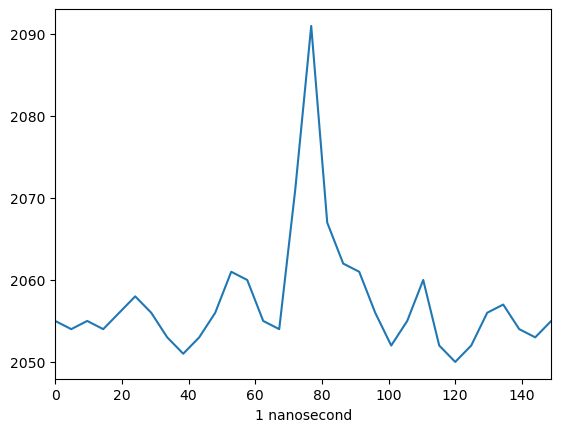

In [8]:
entry_no=6
browser = WaveformBrowser(
    RAW_PATH + "pone_meets_legend_gain_95_raw.lh5",
    "ch002/raw",
    dsp_config=config,
    lines=["waveform"],
    n_drawn=1,
)
browser.draw_entry(entry_no) # plot

In [9]:
# Access the single waveform
waveforms = browser.lines["waveform"]
if len(waveforms) == 1:  # Ensure there is exactly one waveform
    wf = waveforms[0]
    wf_data = wf.get_ydata()  # Directly get the single waveform's data
    print("Raw waveform:", wf_data) # see how it looks like
else:
    raise ValueError(f"Expected 1 waveform, found {len(waveforms)}")

x_data = wf.get_xdata()

Raw waveform: [2055. 2054. 2055. ... 2054. 2053. 2055.]


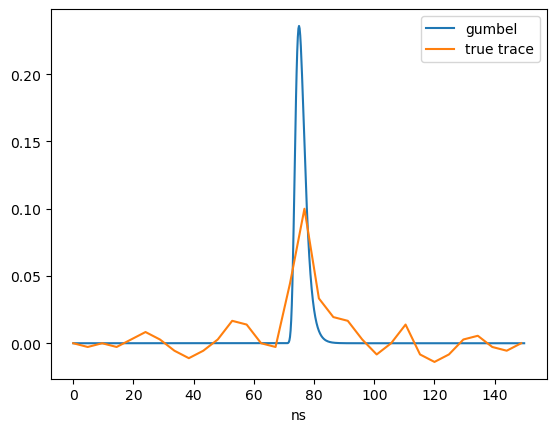

In [10]:
# true data for time and values
x = x_data
y = wf_data - wf_data[0] # correct for 0 baseline
y = y/np.sum(y)/(x_data[1]-x_data[0]) # normalize 

# plot to check
yd = gumbel_pdf(np.arange(0,150, 0.2),75,2) # check how the gumbel looks 
plt.plot(np.arange(0,150, 0.2),yd, label = "gumbel")
plt.plot(x,y, label = "true trace")
plt.xlabel('ns')
plt.legend()


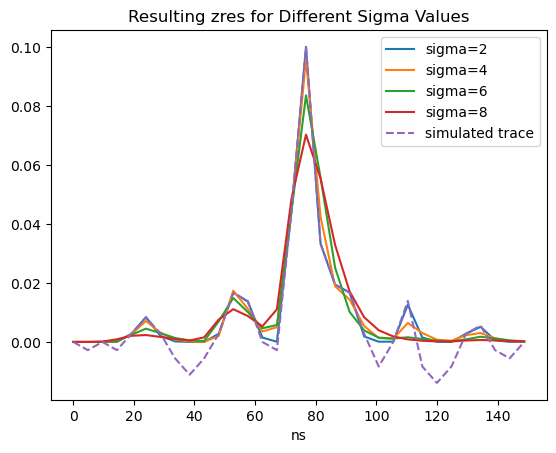

In [11]:
# Define the sigma values to loop over
sigma_values = [2, 4, 6, 8]

# Loop over sigma values
for sigma in sigma_values:
    # Initialize A matrix
    A = np.zeros((len(x), len(x)))
    for i in range(len(x)):
        A[:, i] = gumbel_pdf(x, x[i], sigma)
    
    # Run NNLS
    res = nnls(A, y)
    zres = np.zeros(len(x))
    for i in range(len(zres)):
        zres += res[i] * gumbel_pdf(x, x[i], sigma)
    
    # Plot the result for the current sigma - overshoots the noise
    plt.plot(x, zres, label=f'sigma={sigma}')
plt.plot(x,y,label='simulated trace', linestyle="--")
plt.xlabel('ns')
plt.legend()
plt.title('Resulting zres for Different Sigma Values')
plt.show()


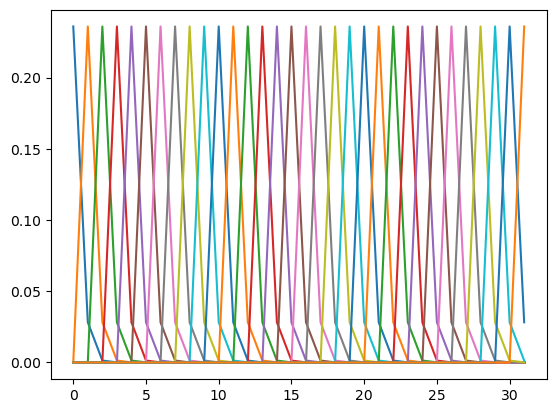

In [12]:
# generate matrix for just one width value for clearer plotting
B = np.zeros((len(x),len(x)))
for i in range(len(x)):
    B[:,i] = gumbel_pdf(x,x[i],2)

# check it is creating the square matrix correctly without downsampling
plt.plot(B) # can comment this out 

# run nnls 
res_B = nnls(B,y)
zres_B = np.zeros(len(x))
for i in range(len(zres_B)):
    zres_B += res_B[i]*(gumbel_pdf(x,x[i],2))

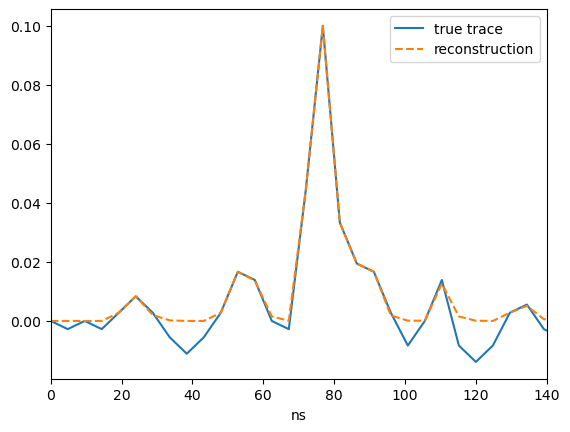

In [13]:
# plot 1 p.e.
plt.plot(x,y,label='true trace')
plt.plot(x,zres_B,label='reconstruction',ls='--')
plt.xlim(0,140)
plt.xlabel('ns')
plt.legend()

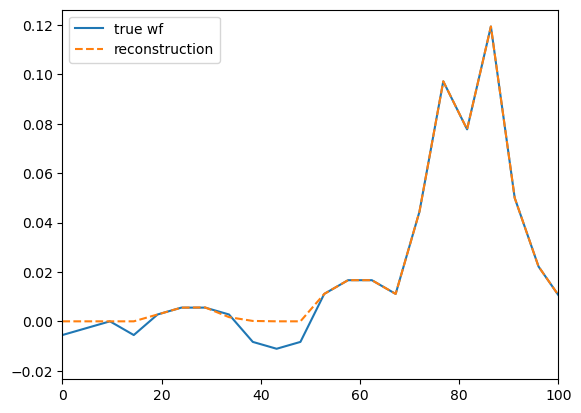

In [14]:
# lets try 2 pe
smpl_roll = 2
yd2 = y+np.roll(y,smpl_roll)

res2 = nnls(B,yd2,1000)
zres2 = np.zeros(len(x))
for i in range(len(zres2)):
    zres2 += res2[i]*(gumbel_pdf(x,x[i],2))

plt.plot(x,y+np.roll(y,smpl_roll),label='true wf')
plt.plot(x,zres2,label='reconstruction',ls='--')
plt.xlim(0,100)
plt.legend()


# Compare with pygama upsampling

# Vary amplitude and t0 to check robustness of modelling technique